In [2]:
from utils.card_generator import get_card_generator

from matplotlib import pyplot as plt

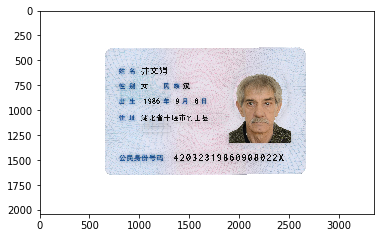

In [3]:
generator = get_card_generator(
    template_path="./data/Chinese_card_constructor2.png",
    face_dir_path="./data/face300_mod2/",
)

plt.imshow(generator.__next__());